Initial setup and first topic model run

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import wosis
import pandas as pd
import metaknowledge as mk

C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\fuzzywuzzy-0.17.0-py3.6.egg\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

In [5]:
# Read in data from temporary cache file
query_id = "756d39801152fe5f5f4ad3a3df9b6a30"
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

expected_num_records = 15754
num_records = len(RC)

assert num_records == expected_num_records, \
    "Mismatch in number of records - expected {}, got {}".format(expected_num_records, num_records)

print("Corpora consists of", num_records, "Publications")

Corpora consists of 15754 Publications


In [6]:
corpora_df = wosis.rc_to_df(RC)

corpora_df, removed_pubs = wosis.constrain.remove_empty_DOIs(corpora_df)
#maybe we don't want to do this for this analysis? older papers less likely to have dois?

Removing 1799 records with no DOIs


In [7]:
# removed_pubs

In [8]:
# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

,year,title,AU,SO
0,2017,VPS: VORONOI PIECEWISE SURROGATE MODELS FOR HI...,"Rushdi, Ahmad A.|Swiler, Laura P.|Phipps, Eric...",INTERNATIONAL JOURNAL FOR UNCERTAINTY QUANTIFI...
1,2011,Small Catchment Agricultural Management Using ...,"Colin, Francois|Guillaume, Serge|Tisseyre, Bruno",WATER RESOURCES MANAGEMENT
2,2011,ON A POLYNOMIAL CHAOS METHOD FOR DIFFERENTIAL ...,"Jung, Jae-Hun|Song, Yunfei",INTERNATIONAL JOURNAL FOR UNCERTAINTY QUANTIFI...
4,2014,Marginal Posterior Simulation via Higher-order...,"Ruli, Erlis|Sartori, Nicola|Ventura, Laura",BAYESIAN ANALYSIS
5,2016,Complex dynamics of a discrete-time predator-p...,"Cui, Qianqian|Zhang, Qiang|Qiu, Zhipeng|Hu, Ze...",CHAOS SOLITONS & FRACTALS


In [9]:
# Create a new metaknowledge collection
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

In [10]:
from wosis.analysis import find_topics

filtered_corpora_df = wosis.rec_to_df(filtered_corpora)
topic_results = find_topics(filtered_corpora_df, num_topics=5)

Topic 1: model water soil flow parameters sensitivity river data groundwater analysis
Topic 2: optimization design method shape topology sensitivity problem element finite analysis
Topic 3: energy cycle environmental life emissions production assessment waste impact lca
Topic 4: uncertainty model models stochastic data analysis method quantification parameter carlo
Topic 5: risk exposure assessment health cancer risks human flood probabilistic analysis


In [11]:
topic_pubs = {
    'model': topic_results.get_topic_by_id(4),
    # 'UA': topic_results.get_topic_by_id(8),
    # 'SA': topic_results.get_topic_by_id(20),    
}

# len(topic_pubs['model']), len(topic_pubs['UA'])
len(topic_pubs['model'])

3203

In [12]:
# find paper of interest - see if it's still in the corpora
for i in range(1,6):
    topic_set = topic_results.get_topic_by_id(i)
    topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')
    tmp_df = wosis.rc_to_df(topic_recs)
    
    if len(tmp_df.loc[tmp_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]) > 0:
        print("Found paper in topic", i)
        break

Found paper in topic 4


In [13]:
topic_4_set = topic_results.get_topic_by_id(4)

In [14]:
topic_4_set.loc[:, ~topic_4_set.columns.isin(hide_columns)].head(10)

,year,title,AU,SO
0,2017,VPS: VORONOI PIECEWISE SURROGATE MODELS FOR HI...,"Rushdi, Ahmad A.|Swiler, Laura P.|Phipps, Eric...",INTERNATIONAL JOURNAL FOR UNCERTAINTY QUANTIFI...
2,2011,ON A POLYNOMIAL CHAOS METHOD FOR DIFFERENTIAL ...,"Jung, Jae-Hun|Song, Yunfei",INTERNATIONAL JOURNAL FOR UNCERTAINTY QUANTIFI...
4,2014,Marginal Posterior Simulation via Higher-order...,"Ruli, Erlis|Sartori, Nicola|Ventura, Laura",BAYESIAN ANALYSIS
11,2008,Sensitivity of population viability to spatial...,"Curtis, J. M. R.|Naujokaitis-Lewis, I.",ECOLOGICAL APPLICATIONS
17,2010,Efficient regularization and uncertainty analy...,"Moore, Catherine|Woehling, Thomas|Doherty, John",WATER RESOURCES RESEARCH
18,2016,A well-posed and stable stochastic Galerkin fo...,"Pettersson, Per|Nordstrom, Jan|Doostan, Alireza",JOURNAL OF COMPUTATIONAL PHYSICS
31,2011,Structural reliability analysis based on rando...,"Jiang, C.|Li, W. X.|Han, X.|Liu, L. X.|Le, P. H.",COMPUTERS & STRUCTURES
56,2010,NPUA: A new approach for the analysis of compu...,"Dette, Holger|Pepelyshev, Anrey",CHEMOMETRICS AND INTELLIGENT LABORATORY SYSTEMS
60,2000,SCRAM: A scoring and ranking system for persis...,"Snyder, EM|Snyder, SA|Giesy, JP|Blonde, SA|Hur...",ENVIRONMENTAL SCIENCE AND POLLUTION RESEARCH
65,2016,Developing population models with data from ma...,"Ryu, Hae Yeong|Shoemaker, Kevin T.|Kneip, Eva|...",BIOLOGICAL CONSERVATION


In [15]:
topic_4_recs = wosis.extract_recs(topic_4_set.loc[:, 'id'], RC, 'Topic of Interest')

In [16]:
#run topic model on topic 4
topic_4_subtopics = find_topics(topic_4_set, num_topics=5)

C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Topic 1: uncertainty model uncertainties analysis water data quality models assessment modeling
Topic 2: stochastic polynomial chaos random quantification equations method expansion collocation solution
Topic 3: sensitivity analysis model models global parameters indices input based output
Topic 4: bayesian model data parameter models calibration inference posterior prior estimation
Topic 5: carlo monte sampling method probability simulation failure distribution reliability function


<hr>

Plotting subtopic trends over time. <br>
Two topics are chosen, papers focusing on applications of SA and papers focusing on theoretical development of SA. <br>
The next task is to superimpose the category trends over time. <br>
Journal publication trends and top cited papers to indicate which fields are applying or interested in the theory of UA/SA. <br>
Author citation networks to indicate which fields are collaborating.

In [17]:
subtopic1 = topic_4_subtopics.get_topic_by_id(1)
subtopic3 = topic_4_subtopics.get_topic_by_id(3)
subtopic4 = topic_4_subtopics.get_topic_by_id(4)

In [18]:
uncertainty_model__applications = wosis.extract_recs(subtopic1['id'], RC, name='applications')

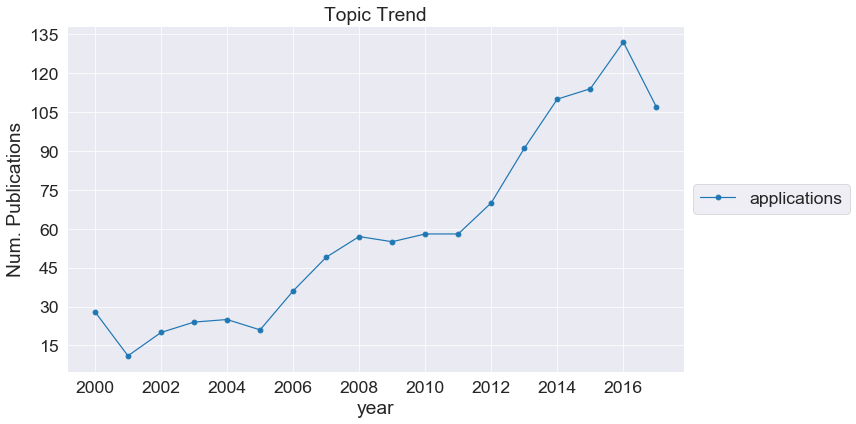

In [19]:
wos_plot.plot_topic_trend([uncertainty_model__applications, ], total_rc=None, title='Topic Trend')

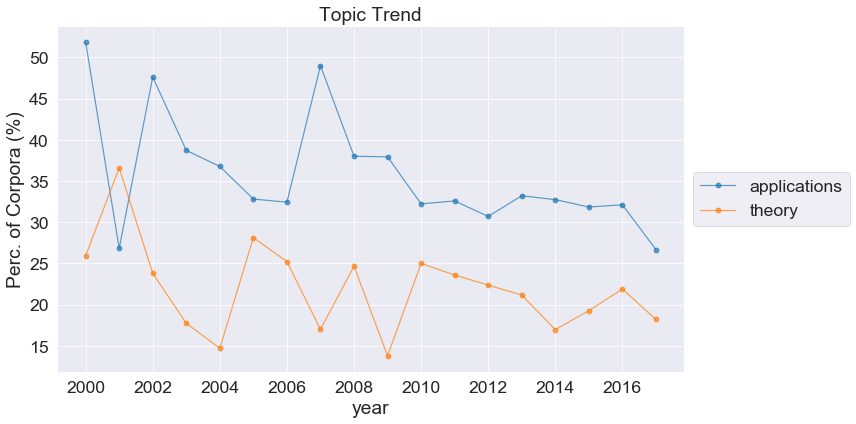

In [68]:
uncertainty_model__sa = wosis.extract_recs(subtopic3['id'], RC, name='theory')

wos_plot.plot_topic_trend([uncertainty_model__applications, uncertainty_model__sa], total_rc=topic_recs, title='Topic Trend', save_plot_fn='App and Theory Topic Trend Percentage')

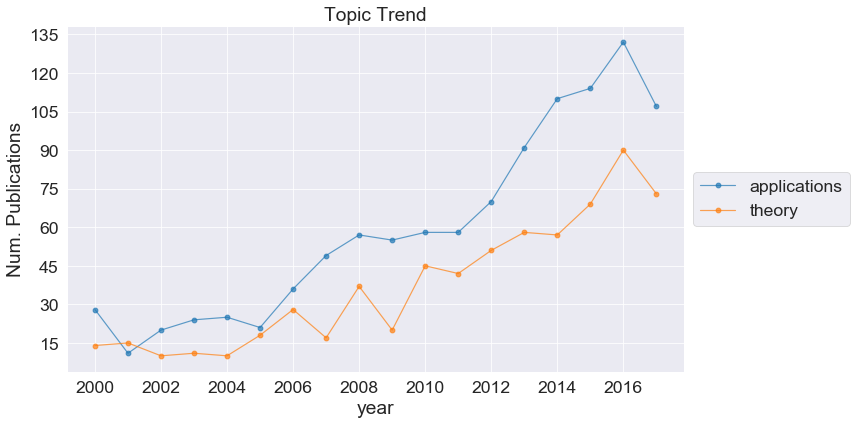

In [69]:
wos_plot.plot_topic_trend([uncertainty_model__applications, uncertainty_model__sa], total_rc=None, title='Topic Trend', save_plot_fn='App and Theory Topic Trend')

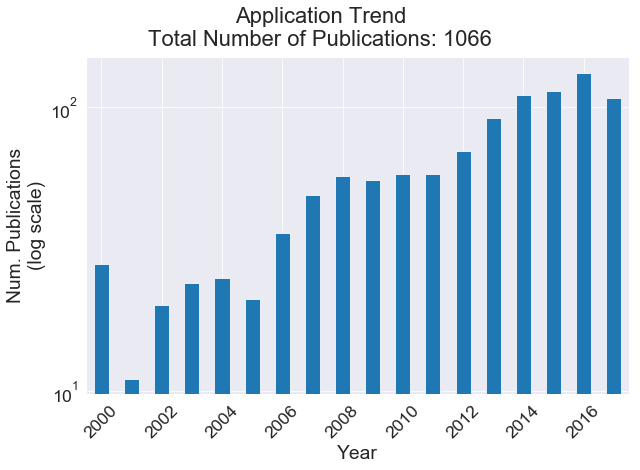

In [102]:
wos_plot.plot_pub_trend(uncertainty_model__applications, title='Application Trend', save_plot_fn='apptrend_2000-2016.png')
#not sure if it's possible to superimpose these graphs due to the plot_pub_trend function setup

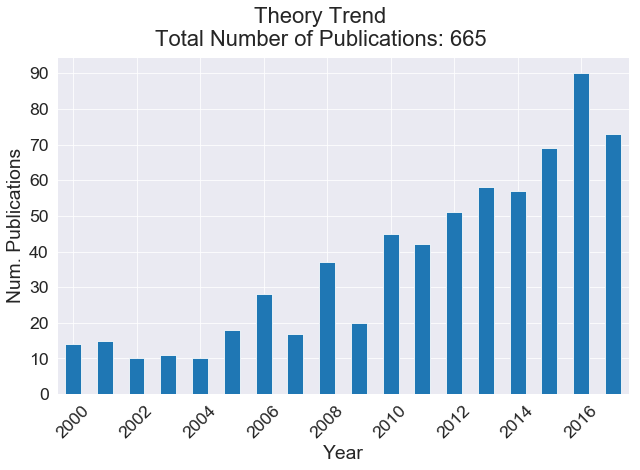

In [23]:
wos_plot.plot_pub_trend(uncertainty_model__sa, title='Theory Trend', save_plot_fn='theotrend_2000-2016.png')

In [24]:
#topic 2 of interest
uncertainty_model__applications_df = wosis.rec_to_df(uncertainty_model__applications)
topic_results = find_topics(uncertainty_model__applications_df, num_topics=5)

Topic 1: model analysis models data uncertainties parameters modeling using method results
Topic 2: glue parameter model calibration hydrological likelihood swat watershed estimation generalized
Topic 3: flood inundation damage forecasting mapping maps forecasts historical rainfall probabilistic
Topic 4: quality urban modelling drainage water stormwater pollutant integrated sewer data
Topic 5: dose doses internal deposition distributions public uncertainties values individual exposure


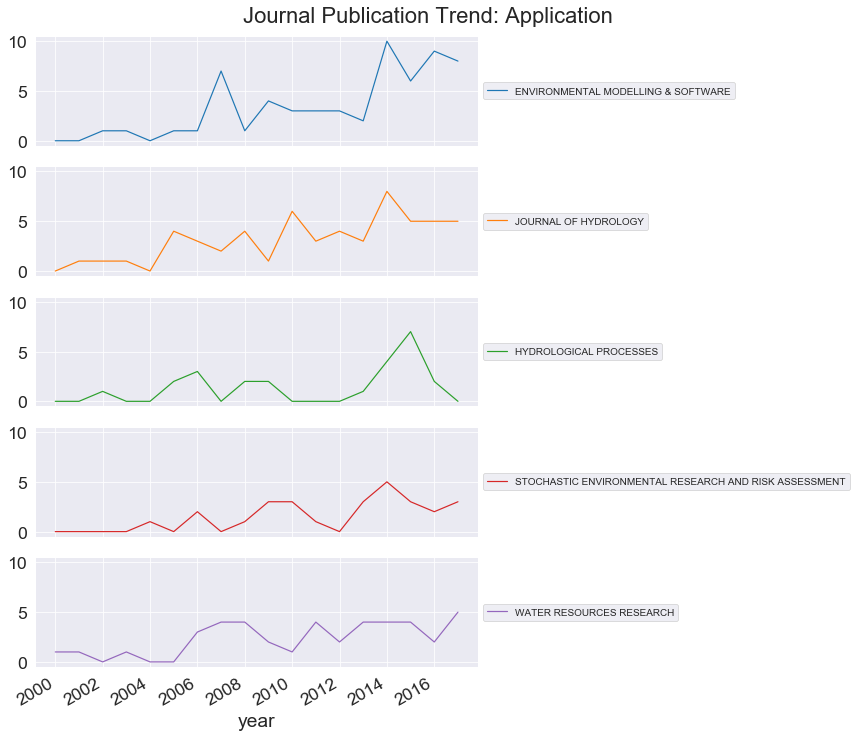

In [64]:
wos_plot.plot_journal_pub_trend((uncertainty_model__applications), top_n=5, title='Journal Publication Trend: Application', save_plot_fn='journal_app_trend.png')

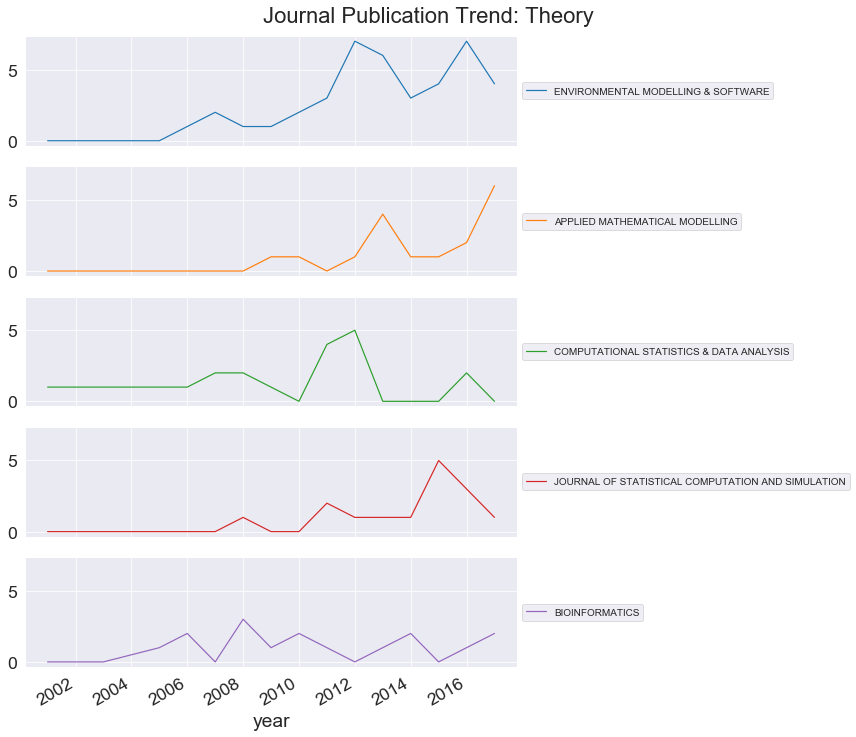

In [65]:
wos_plot.plot_journal_pub_trend((uncertainty_model__sa), top_n=5, title='Journal Publication Trend: Theory', save_plot_fn='journal_theo_trend.png')

In [80]:
journals_of_interest = ['Environmental Modelling & Software'.upper(), 'Journal of Hydrology'.upper(),
                       'Hydrological Processes'.upper(), 'Stochastic Environmental Research and Risk Assessment'.upper(), 'Water Resources Research'.upper()]
pubs_for_journals_apps = wosis.find_pubs_by_journal(uncertainty_model__applications, journals_of_interest)

In [81]:
import glob

data_dir = "tmp"  # Using the temporary data directory
wos_config = wosis.load_config("config.yml")

# Get citations for each paper
paper_citations_per_journal_apps = {}
for pubs in pubs_for_journals_apps:
    fn = '{}/{}_citations_apps.csv'.format(data_dir, pubs)
    file_list = glob.glob(fn)
    if not file_list:
        # Get citation data if not already downloaded and saved
        paper_citations_per_journal_apps[pubs] = wosis.get_num_citations(pubs_for_journals_apps[pubs], wos_config)
        paper_citations_per_journal_apps[pubs].to_csv(fn)
    else:
        # If available, load the saved data
        paper_citations_per_journal_apps[pubs] = pd.read_csv(fn)

Authenticated (SID: 7DHQdc1DNMM57nLBUZ1)


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:18<00:00,  1.67it/s]


Authenticated (SID: 6BtsbFsUwCEhrDhWqct)


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:13<00:00,  1.73it/s]


In [82]:
journal_apps = paper_citations_per_journal_apps['JOURNAL OF HYDROLOGY']

journal_apps = journal_apps.set_index(journal_apps.title)

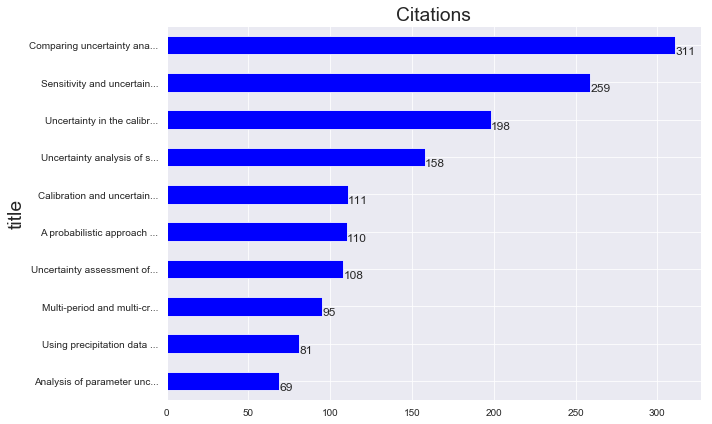

In [83]:
wos_plot.plot_citations(journal_apps)

In [84]:
journal_apps[['AU', 'year', 'DOI']][0:5]

,AU,year,DOI
title,,,
Comparing uncertainty ana...,"Yang, Jing|Reichert, Peter|Abbaspour, K. C.|Xi...",2008,10.1016/j.jhydrol.2008.05.012
Sensitivity and uncertain...,"Muleta, MK|Nicklow, JW",2005,10.1016/j.jhydrol.2004.09.005
Uncertainty in the calibr...,"Pappenberger, F|Beven, K|Horritt, M|Blazkova, S",2005,10.1016/j.jhydrol.2004.06.036
Uncertainty analysis of s...,"Khan, MS|Coulibaly, P|Dibike, Y",2006,10.1016/j.jhydrol.2005.06.035
Calibration and uncertain...,"Zhang, Xuesong|Srinivasan, Raghavan|Bosch, David",2009,10.1016/j.jhydrol.2009.06.023


In [85]:
cols_of_interest = ['AU', 'year', 'title', 'journal', 'citations', 'DOI link']
collection = pd.DataFrame(columns=cols_of_interest)
for journal_apps, df in paper_citations_per_journal_apps.items():
    df = wosis.link_to_pub(df)
    df['journal'] = journal_apps
    df['DOI link'] = df['DOI link'].str.replace('envost', 'envsoft')  # fix incorrect DOI link
    collection_apps = collection.append(df[cols_of_interest][0:10], ignore_index=True)

In [86]:
top_cited_in_top_journals_apps = collection_apps.sort_values('citations', ascending=False)

top_cited_in_top_journals_apps.head(10)

,AU,year,title,journal,citations,DOI link
0,"Pappenberger, F.|Beven, K. J.",2006,Ignorance is bliss: Or seven reasons not to us...,WATER RESOURCES RESEARCH,244,https://dx.doi.org/10.1029/2005WR004820
1,"Stedinger, Jery R.|Vogel, Richard M.|Lee, Seun...",2008,Appraisal of the generalized likelihood uncert...,WATER RESOURCES RESEARCH,137,https://dx.doi.org/10.1029/2008WR006822
2,"Matott, L. Shawn|Babendreier, Justin E.|Puruck...",2009,Evaluating uncertainty in integrated environme...,WATER RESOURCES RESEARCH,115,https://dx.doi.org/10.1029/2008WR007301
3,"Hong, Yang|Hsu, Kuo-lin|Moradkhani, Hamid|Soro...",2006,Uncertainty quantification of satellite precip...,WATER RESOURCES RESEARCH,99,https://dx.doi.org/10.1029/2005WR004398
4,"Coxon, G.|Freer, J.|Westerberg, I. K.|Wagener,...",2015,A novel framework for discharge uncertainty qu...,WATER RESOURCES RESEARCH,49,https://dx.doi.org/10.1002/2014WR016532
5,"Doherty, John|Christensen, Steen",2011,Use of paired simple and complex models to red...,WATER RESOURCES RESEARCH,47,https://dx.doi.org/10.1029/2011WR010763
6,"Goetzinger, Jens|Bardossy, Andras",2008,Generic error model for calibration and uncert...,WATER RESOURCES RESEARCH,44,https://dx.doi.org/10.1029/2007WR006691
7,"Srivastav, R. K.|Sudheer, K. P.|Chaubey, I.",2007,A simplified approach to quantifying predictiv...,WATER RESOURCES RESEARCH,42,https://dx.doi.org/10.1029/2006WR005352
8,"Ragettli, S.|Pellicciotti, F.|Bordoy, R.|Immer...",2013,Sources of uncertainty in modeling the glacioh...,WATER RESOURCES RESEARCH,38,https://dx.doi.org/10.1002/wrcr.20450
9,"Wu, Bin|Zheng, Yi|Tian, Yong|Wu, Xin|Yao, Ying...",2014,Systematic assessment of the uncertainty in in...,WATER RESOURCES RESEARCH,37,https://dx.doi.org/10.1002/2014WR015366


In [87]:
top_cited_in_top_journals_apps.to_csv('top_cited_in_top_journals_apps.csv', index=False)

In [88]:
journals_of_interest = ['Environmental Modelling & Software'.upper(), 'Applied Mathematical Modelling'.upper(),
                       'Computational Statistics & Data Analysis'.upper(), 'Journal of Statistical Computation and Simulation'.upper(), 'Bioinformatics'.upper()]
pubs_for_journals_theo = wosis.find_pubs_by_journal(uncertainty_model__sa, journals_of_interest)

In [92]:
data_dir = "tmp"  # Using the temporary data directory
wos_config = wosis.load_config("config.yml")

# Get citations for each paper
paper_citations_per_journal_theo = {}
for pubs in pubs_for_journals_theo:
    fn = '{}/{}_citations.csv_theo'.format(data_dir, pubs)
    file_list = glob.glob(fn)
    if not file_list:
        # Get citation data if not already downloaded and saved
        paper_citations_per_journal_theo[pubs] = wosis.get_num_citations(pubs_for_journals_theo[pubs], wos_config)
        paper_citations_per_journal_theo[pubs].to_csv(fn)
    else:
        # If available, load the saved data
        paper_citations_per_journal_theo[pubs] = pd.read_csv(fn)

Authenticated (SID: 5BP8JvMeZ2rJA8V6bv3)


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.06it/s]


In [94]:
journal_theo = paper_citations_per_journal_theo['BIOINFORMATICS']

journal_theo = journal_theo.set_index(journal_theo.title)

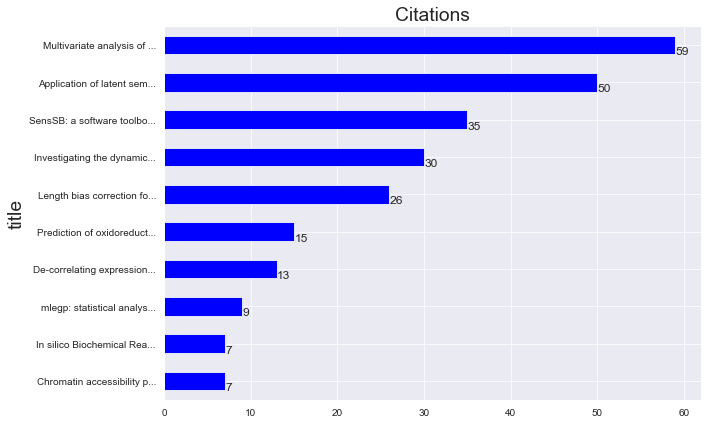

In [95]:
wos_plot.plot_citations(journal_theo)

In [96]:
journal_theo[['AU', 'year', 'DOI']][0:5]

,AU,year,DOI
title,,,
Multivariate analysis of ...,"Tsai, Chen-An|Chen, James J.",2009,10.1093/bioinformatics/btp098
Application of latent sem...,"Dong, QW|Wang, XL|Lin, L",2006,10.1093/bioinformatics/bti801
SensSB: a software toolbo...,"Rodriguez-Fernandez, Maria|Banga, Julio R.",2010,10.1093/bioinformatics/btq242
Investigating the dynamic...,"Haunschild, MD|Freisleben, B|Takors, R|Wiecher...",2005,10.1093/bioinformatics/bti225
Length bias correction fo...,"Gao, Liyan|Fang, Zhide|Zhang, Kui|Zhi, Degui|C...",2011,10.1093/bioinformatics/btr005


In [97]:
cols_of_interest = ['AU', 'year', 'title', 'journal', 'citations', 'DOI link']
collection = pd.DataFrame(columns=cols_of_interest)
for journal_theo, df in paper_citations_per_journal_theo.items():
    df = wosis.link_to_pub(df)
    df['journal'] = journal_theo
    df['DOI link'] = df['DOI link'].str.replace('envost', 'envsoft')  # fix incorrect DOI link
    collection_theo = collection.append(df[cols_of_interest][0:10], ignore_index=True)

In [98]:
top_cited_in_top_journals_theo = collection_theo.sort_values('citations', ascending=False)

top_cited_in_top_journals_theo.head(10)

,AU,year,title,journal,citations,DOI link
0,"Mara, Thierry Alex|Joseph, Onimihamina Rakoto",2008,Comparison of some efficient methods to evalua...,JOURNAL OF STATISTICAL COMPUTATION AND SIMULATION,21,https://dx.doi.org/10.1080/10629360600964454
1,"Da Veiga, Sebastien",2015,Global sensitivity analysis with dependence me...,JOURNAL OF STATISTICAL COMPUTATION AND SIMULATION,14,https://dx.doi.org/10.1080/00949655.2014.945932
2,"Chastaing, G.|Gamboa, F.|Prieur, C.",2015,Generalized Sobol sensitivity indices for depe...,JOURNAL OF STATISTICAL COMPUTATION AND SIMULATION,12,https://dx.doi.org/10.1080/00949655.2014.960415
3,"Tissot, J-Y.|Prieur, C.",2015,A randomized orthogonal array-based procedure ...,JOURNAL OF STATISTICAL COMPUTATION AND SIMULATION,11,https://dx.doi.org/10.1080/00949655.2014.971799
4,"Jamshidian, Mortaza|Yuan, Ke-Hai",2013,Data-driven sensitivity analysis to detect mis...,JOURNAL OF STATISTICAL COMPUTATION AND SIMULATION,5,https://dx.doi.org/10.1080/00949655.2012.660486
5,"Chastaing, G.|Le Gratiet, L.",2015,ANOVA decomposition of conditional Gaussian pr...,JOURNAL OF STATISTICAL COMPUTATION AND SIMULATION,4,https://dx.doi.org/10.1080/00949655.2014.925111
6,"Xu, Chonggang|Gertner, George Zdzislaw",2011,Reliability of global sensitivity indices,JOURNAL OF STATISTICAL COMPUTATION AND SIMULATION,4,https://dx.doi.org/10.1080/00949655.2010.509317
7,"Cancho, Vicente G.|Ortega, Edwin M. M.|Barriga...",2011,The Conway-Maxwell-Poisson-generalized gamma r...,JOURNAL OF STATISTICAL COMPUTATION AND SIMULATION,4,https://dx.doi.org/10.1080/00949655.2010.491827
8,"Liu, Shuangzhe|Polasek, Wolfgang|Sellner, Richard",2012,Sensitivity analysis of SAR estimators: a nume...,JOURNAL OF STATISTICAL COMPUTATION AND SIMULATION,3,https://dx.doi.org/10.1080/00949655.2012.656369
9,"De Lozzo, Matthias|Marrel, Amandine",2016,New improvements in the use of dependence meas...,JOURNAL OF STATISTICAL COMPUTATION AND SIMULATION,2,https://dx.doi.org/10.1080/00949655.2016.1149854


In [99]:
top_cited_in_top_journals_theo.to_csv('top_cited_in_top_journals_theo.csv', index=False)

In [43]:
# import network packages
import metaknowledge as mk
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
# co-author network
coAuths_apps = uncertainty_model__applications.networkCoAuthor()
print(mk.graphStats(coAuths_apps))

Nodes: 3512
Edges: 9236
Isolates: 47
Self loops: 0
Density: 0.00149806
Transitivity: 0.921657


C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\networkx-2.2-py3.6.egg\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


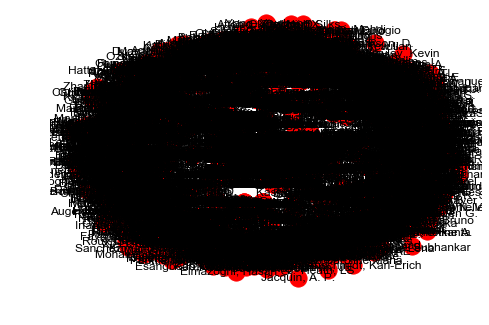

In [45]:
nx.draw_spring(coAuths_apps, with_labels=True)

In [46]:
minWeight = 3
maxWeight = 10
proccessedcoAuths_apps = coAuths_apps.copy()
mk.dropEdges(proccessedcoAuths_apps, minWeight, maxWeight, dropSelfLoops=True)
mk.graphStats(proccessedcoAuths_apps)

'Nodes: 3512\nEdges: 65\nIsolates: 3442\nSelf loops: 0\nDensity: 1.05428E-05\nTransitivity: 0.956044'

In [47]:
mk.dropNodesByDegree(proccessedcoAuths_apps, 1)
mk.graphStats(proccessedcoAuths_apps)

'Nodes: 70\nEdges: 65\nIsolates: 0\nSelf loops: 0\nDensity: 0.0269151\nTransitivity: 0.956044'

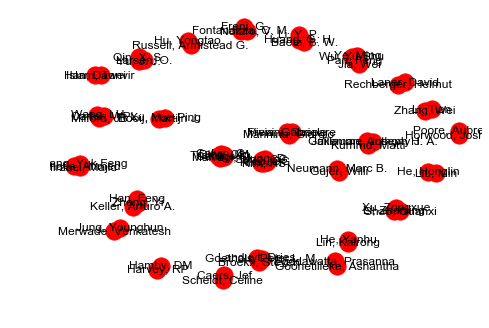

In [48]:
nx.draw_spring(proccessedcoAuths_apps, with_labels=True)

In [49]:
# co-author network
coAuths_theo = uncertainty_model__sa.networkCoAuthor()
print(mk.graphStats(coAuths_theo))

Nodes: 2146
Edges: 4796
Isolates: 45
Self loops: 2
Density: 0.00208378
Transitivity: 0.954153


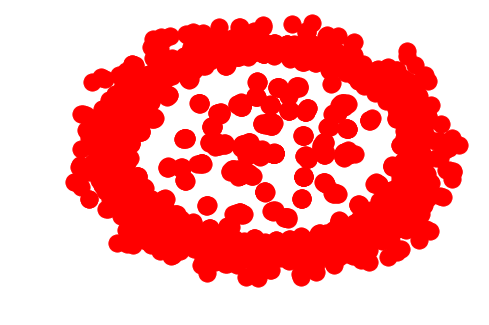

In [50]:
nx.draw_spring(coAuths_theo, with_labels=False)

In [51]:
minWeight = 3
maxWeight = 10
proccessedcoAuths_theo = coAuths_theo.copy()
mk.dropEdges(proccessedcoAuths_theo, minWeight, maxWeight, dropSelfLoops=True)
mk.graphStats(proccessedcoAuths_theo)

'Nodes: 2146\nEdges: 25\nIsolates: 2120\nSelf loops: 0\nDensity: 1.08621E-05\nTransitivity: 0.976744'

In [52]:
mk.dropNodesByDegree(proccessedcoAuths_theo, 1)
mk.graphStats(proccessedcoAuths_theo)

'Nodes: 26\nEdges: 25\nIsolates: 0\nSelf loops: 0\nDensity: 0.0769231\nTransitivity: 0.976744'

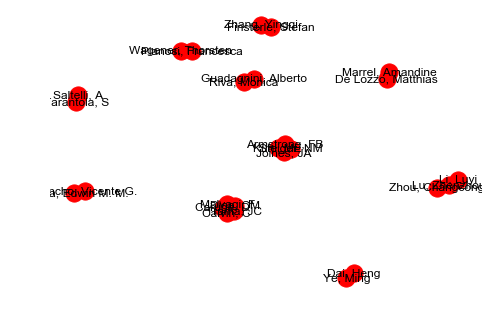

In [53]:
nx.draw_spring(proccessedcoAuths_theo, with_labels=True)

In [70]:
coCiteJournals_apps = uncertainty_model__applications.networkCoCitation(nodeType = 'journal', dropNonJournals = True)
print(mk.graphStats(coCiteJournals_apps))

Nodes: 228
Edges: 254
Isolates: 79
Self loops: 22
Density: 0.00981529
Transitivity: 0.486708


In [75]:
minWeight = 3
maxWeight = 10
proccessedcoCiteJournals_apps = coCiteJournals_apps.copy()
mk.dropEdges(proccessedcoCiteJournals_apps, minWeight, maxWeight, dropSelfLoops=True)
mk.graphStats(proccessedcoCiteJournals_apps)

'Nodes: 228\nEdges: 18\nIsolates: 205\nSelf loops: 0\nDensity: 0.000695572\nTransitivity: 0'

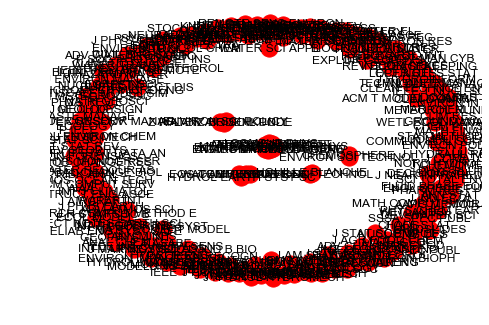

In [76]:
nx.draw_spring(proccessedcoCiteJournals_apps, with_labels=True)

In [71]:
coCiteJournals_theo = uncertainty_model__sa.networkCoCitation(nodeType = 'journal', dropNonJournals = True)
print(mk.graphStats(coCiteJournals_theo))

Nodes: 179
Edges: 101
Isolates: 82
Self loops: 10
Density: 0.00633984
Transitivity: 0.632432


In [77]:
minWeight = 3
maxWeight = 10
proccessedcoCiteJournals_theo = coCiteJournals_theo.copy()
mk.dropEdges(proccessedcoCiteJournals_theo, minWeight, maxWeight, dropSelfLoops=True)
mk.graphStats(proccessedcoCiteJournals_theo)

'Nodes: 179\nEdges: 2\nIsolates: 175\nSelf loops: 0\nDensity: 0.000125541\nTransitivity: 0'

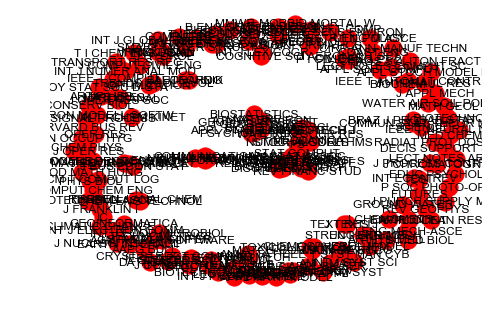

In [78]:
nx.draw_spring(coCiteJournals_theo, with_labels=True)

<hr>

Here the results to app_paper are sorted with reference to the packages they support.
<br> Still to complete: plot each criterion's trend

In [54]:
#keyword criteria match on app_papers
#want to see trend of keywords over time
#add languages
uncertainty_topic_df = topic_results.get_topic_by_id(4)

uncertainty_models_rc = wosis.extract_recs(subtopic1.loc[:, 'id'], RC, 'Topic of Interest')
# topic_4_1_recs = wosis.extract_recs(subtopic1.loc[:, 'id'], RC, 'Topic of Interest')

criteria = {
    'GLUE': set(['GLUE', 'generalized likelihood uncertainty estimation', 'distributed models', 'calibration uncertainty', 'likelihood', 'uncertainty estimation', 'epistemic error', 'rainfall-runoff models', 'equifinality', 'Plynlimon']),
    'PEST': set(['PEST', 'parameter estimation', 'model-independent parameter estimation & uncertainty analysis', 'user interfaces', 'computer systems', 'data processing', 'least squares', 'spatial systems', 'mathematical models', 'software']),
    'SALib': set(['salib', 'sensitivity analysis', 'python', 'uncertainty', 'variance-based', 'global sensitivity analysis', 'fractional factorial', 'method of morris']),
    'MADS': set(['sensitivity analysis', 'MADS', 'julia', 'julialang', 'parameter estimation', 'model inversion & calibration', 'uncertainty quantification', 'model selection', 'model averaging', 'model reduction', 'surrogate modeling', 'machine learning', 'blind source separation', 'decision analysis & support']),
    'PSUADE': set(['uncertainty quantification', 'sensitivity analysis', 'parameter estimation', 'space-filling sample', 'PSUADE', 'Problem Solving environment for Uncertainty Analysis and Design Exploration']),
    'SAFE': set(['global sensitivity analysis', 'matlab', 'octave', 'open-source software', 'safe', 'sensitivity analysis for everyone']),
    'VARS-TOOL': set(['VARS-TOOL', 'VARS', 'global sensitivity analysis', 'uncertainty analysis', 'variogram analysis of response surfaces', 'variogram', 'sobol', 'morris', 'progressive latin hypercube sampling', 'plhs', 'dynamical systems models', 'sensitivty indices', 'performance metrics']),
    'UQLab': set(['uncertainty quantification', 'uncertainty analysis', 'sensitivity analysis', 'computer systems', 'uqlab']),
    'DAKOTA': set(['dakota', 'mathematical methods', 'computing', 'computer-aided design', 'finite element method', 'nonlinear programming', 'sensitivity analysis', 'parallel processing', 'stochastic processes', 'integer processing', 'iterative methods', 'computer programs']),
    'HDMR': set(['global sensitivity analysis', 'hdmr', 'high dimensional model representation', 'matlab', 'matlab software', 'graphic user interface', 'gui']),
    'SimLab': set(['sensitivity analysis', 'uncertainty analysis', 'model development', 'global sensitivity analysis', 'simlab'])
}

crit_matches = wosis.keyword_matches_by_criteria(uncertainty_models_rc, criteria, threshold=95.0)

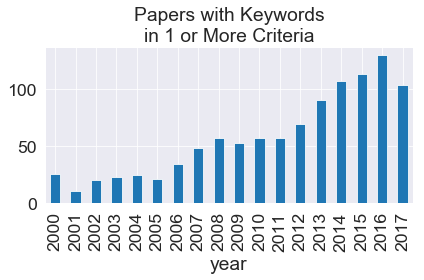

In [55]:
criteria1_df = wosis.collate_keyword_criteria_matches(uncertainty_models_rc, crit_matches)
wos_plot.plot_criteria_trend(criteria1_df, threshold=1)

<hr>

The following includes more analysis of the papers from topic 4 and topic 4.3. <br>
- Publication trends
- Criteria matching and trends of criteria.

In [56]:
uncertainty_sa_df = topic_4_subtopics.get_topic_by_id(3)
uncertainty_sa_rc = wosis.extract_recs(uncertainty_sa_df.loc[:, 'id'], topic_recs, 'Topic of Interest')
# tmp_df = wosis.rc_to_df(uncertainty_sa_rc)

In [57]:
uncertainty_sa_df.loc[:, ~topic_set.columns.isin(hide_columns)].head()

,year,title,AU,SO
11,2008,Sensitivity of population viability to spatial...,"Curtis, J. M. R.|Naujokaitis-Lewis, I.",ECOLOGICAL APPLICATIONS
65,2016,Developing population models with data from ma...,"Ryu, Hae Yeong|Shoemaker, Kevin T.|Kneip, Eva|...",BIOLOGICAL CONSERVATION
81,2012,Generalized estimating equations and regressio...,"Vens, Maren|Ziegler, Andreas",COMPUTATIONAL STATISTICS & DATA ANALYSIS
88,2004,Sensitivity analysis for output performance me...,"Sohn, SY|Lee, SH",COMPUTERS & OPERATIONS RESEARCH
93,2004,A PC-based apparatus for identifying magnetiza...,"Wang, SC|Lan, WH","2004 IEEE SYMPOSIUM ON VIRTUAL ENVIRONMENTS, H..."


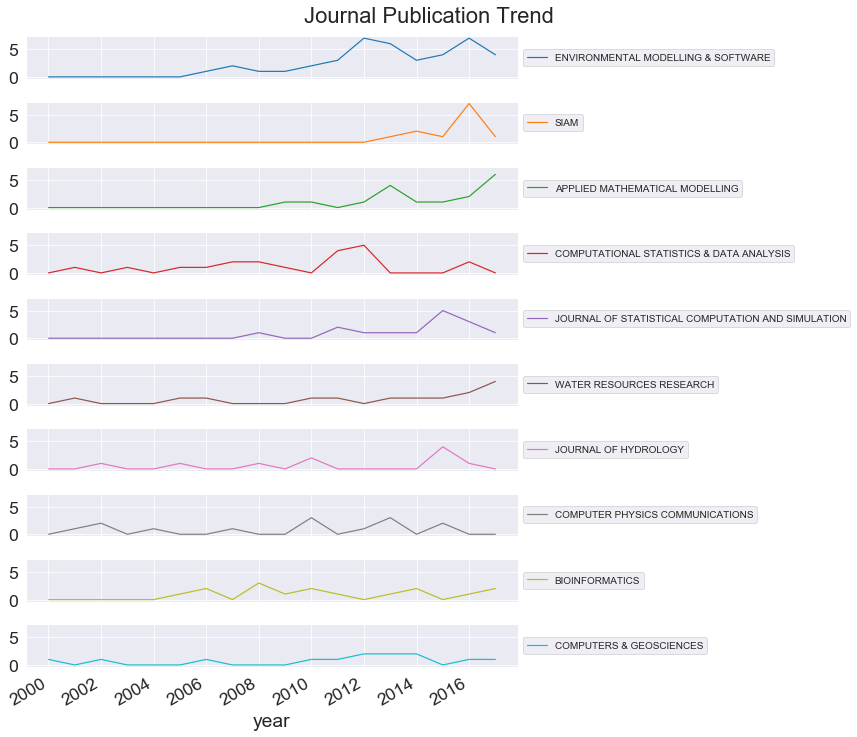

In [58]:
#publication trend for top 10 journals
wos_plot.plot_journal_pub_trend(uncertainty_sa_rc)

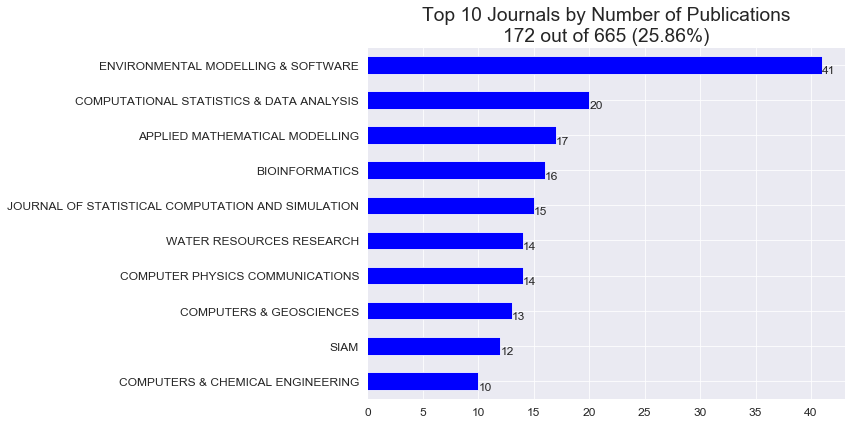

In [59]:
#Top 10 jorunals by number of publications
wos_plot.plot_pubs_per_journal(uncertainty_sa_rc, top_n=10, annotate=True, show_stats=True)

In [60]:
#top papers by cited papers within the corpora
wosis.analysis.pub_citations(uncertainty_sa_rc)[0:5]

#ideas: could take first 1000 by citation number, but higher citations would favour older papers.  Taking by year?
#or simply choose first 1000 matches?

,Citations
Publication,
"Saltelli, A, 1999, A quantitative model-independent method for global sensitivity analysis of model output, TECHNOMETRICS, 41, 39, 6699137",328
"Saltelli, A., 2008, Global Sensitivity Analysis, The Primer, 287698885",183
"Sobol, I. M., 2009, Derivative based global sensitivity measures and their link with global sensitivity indices, MATHEMATICS AND COMPUTERS IN SIMULATION, 79, 3009, 267577835",160
"SOBOL, IM, 1990, QUASI-MONTE-CARLO METHODS, PROGRESS IN NUCLEAR ENERGY, 24, 55, 43362677",111
"Saltelli, Andrea, 2006, Sensitivity analysis practices: Strategies for model-based inference, RELIABILITY ENGINEERING & SYSTEM SAFETY, 91, 1109, 71643703",99


In [61]:
# first 10 papers in chosen topic (unordered)
uncertainty_sa_doi = wosis.link_to_pub(uncertainty_sa_rc)  # Creates a new column called 'DOI link'
uncertainty_sa_doi.loc[:, ~uncertainty_sa_doi.columns.isin(hide_columns)].head(10)

,year,title,AU,SO,DOI link
0,2013,SPSens: a software package for stochastic para...,"Sheppard, Patrick W.|Rathinam, Muruhan|Khammas...",BIOINFORMATICS,https://dx.doi.org/10.1093/bioinformatics/bts642
1,2010,Global sensitivity of structural variability b...,"Patelli, Edoardo|Pradlwarter, Helmut J.|Schuel...",COMPUTER PHYSICS COMMUNICATIONS,https://dx.doi.org/10.1016/j.cpc.2010.08.007
2,2017,Including category information as supplements ...,"Krishnamurthi, Karthik|Panuganti, Vijayapal Re...",INTERNATIONAL JOURNAL OF COMPUTATIONAL SCIENCE...,https://dx.doi.org/10.1504/IJCSE.2017.10006984
3,2005,Deterministic vs. probabilistic analyses to id...,"Kamboj, S|Cheng, JJ|Yu, C",HEALTH PHYSICS,https://dx.doi.org/10.1097/01.HP.0000156058.46...
4,2014,A comprehensive evaluation of various sensitiv...,"Gan, Yanjun|Duan, Qingyun|Gong, Wei|Tong, Char...",ENVIRONMENTAL MODELLING & SOFTWARE,https://dx.doi.org/10.1016/j.envsoft.2013.09.031
5,2015,Coupling models of cattle and farms with model...,"Moustakas, Aristides|Evans, Matthew R.",STOCHASTIC ENVIRONMENTAL RESEARCH AND RISK ASS...,https://dx.doi.org/10.1007/s00477-014-1016-y
6,2008,Sensitivity of population viability to spatial...,"Curtis, J. M. R.|Naujokaitis-Lewis, I.",ECOLOGICAL APPLICATIONS,https://dx.doi.org/10.1890/07-1306.1
7,2009,SENSITIVITY ANALYSIS OF DISTRIBUTED RAINFALL-R...,"Soria, Freddy|Kazama, So|Sawamoto, Masaki|Zhan...",ADVANCES IN WATER RESOURCES AND HYDRAULIC ENGI...,https://dx.doi.org/10.1007/978-3-540-89465-0_5
8,2012,PCA document reconstruction for email classifi...,"Gomez, Juan Carlos|Moens, Marie-Francine",COMPUTATIONAL STATISTICS & DATA ANALYSIS,https://dx.doi.org/10.1016/j.csda.2011.09.023
9,2013,Flexible Mediation Analysis in the Presence of...,"Loeys, Tom|Moerkerke, Beatrijs|De Smet, Olivia...",MULTIVARIATE BEHAVIORAL RESEARCH,https://dx.doi.org/10.1080/00273171.2013.832132


In [62]:
uncertainty_sa_doi.to_csv('topic_4_3.csv')

PermissionError: [Errno 13] Permission denied: 'topic_4_3.csv'

In [ ]:
# want to see trend of global SA over years
# also should make a table of papers, see below
criteria = {
    'LSA': set(['local sensitivity analysis', 'LSA', 'local sensitivity']),
    'GSA': set(['global sensitivity analysis', 'GSA', 'global sensitivity']),
    'OAT': set(['one-at-a-time', 'OAT'])
}

crit_matches = wosis.keyword_matches_by_criteria(uncertainty_sa_rc, criteria, threshold=95.0)

In [ ]:
criteria_df = wosis.collate_keyword_criteria_matches(uncertainty_sa_rc, crit_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=2)

In [ ]:
# want to view the papers in the above plot
# crit_trend_tmp = criteria_df.loc[criteria_df['num_criteria_match'] > 1, ~criteria_df.columns.isin(hide_columns)]
# crit_trend_tmp.groupby('year').count()['title'].plot(kind='bar')

criteria_df.loc[criteria_df['num_criteria_match'] >= 2].sort_values('year').head()

In [ ]:
lsa_matches = wosis.keyword_matches(uncertainty_sa_rc, ['local sensitivity', 'LSA', 'local sensitivity analysis'], threshold=95.0)

In [ ]:
gsa_matches = wosis.keyword_matches(uncertainty_sa_rc, ['global sensitivity', 'GSA', 'global sensitivity analysis'], threshold=95.0)

In [ ]:
oat_matches = wosis.keyword_matches(uncertainty_sa_rc, ['one-at-a-time', 'OAT'], threshold=95.0)

In [ ]:
lsa_matches

In [ ]:
wos_plot.plot_topic_trend([lsa_matches, gsa_matches, oat_matches], 
                          topic_4_recs)

<hr>

Network analysis, cocite and coauthor networks
<br> Further formatting/data extraction required, see networkx documentation

In [ ]:
# import network packages
import metaknowledge as mk
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# co-author network
coAuths = topic_recs.networkCoAuthor()
print(mk.graphStats(coAuths))

In [ ]:
nx.draw_spring(coAuths, with_labels=False)

In [ ]:
# highly cited co-atuhor network, how do I limit nodes? Needs to use topic 1 only, not full data base
minWeight = 3
maxWeight = 10
proccessedcoAuths = coAuths.copy()
mk.dropEdges(proccessedcoAuths, minWeight, maxWeight, dropSelfLoops=True)
mk.graphStats(proccessedcoAuths)

In [ ]:
mk.dropNodesByDegree(proccessedcoAuths, 1)
mk.graphStats(proccessedcoAuths)

In [ ]:
nx.draw_spring(proccessedcoAuths, with_labels=True)

In [ ]:
minWeight = 30
maxWeight = 35
coCites = uncertainty_sa_rc.networkCoCitation()
mk.dropEdges(coCites, minWeight, maxWeight, dropSelfLoops=True)
mk.dropNodesByDegree(coCites, 5)
print(mk.graphStats(coCites))

In [ ]:
nx.draw_spring(coCites, with_labels=True)